<a href="https://colab.research.google.com/github/schwallergroup/ai4chem_course/blob/generative_models/notebooks/05%20-%20Generative%20Models/Molecular%20Generative%20Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Week 5 Tutorial: AI for Chemistry


# Molecular Generative Models

In recent years, there has been an explosion in the number of molecular generative models being developed. Regardless of the formulation, these models share some commonalities:

1. They can generate molecules that are **not** in the training data - therefore, they have the potential to  explore  new chemical space


2. They can be coupled with some optimization algorithm to explicitly tailor the model to generate molecules satisfying some target objective such as possessing high predicted solubility

*You will get the chance to play with [`REINVENT`](https://github.com/MolecularAI/Reinvent) next week which is an open-source SMILES-based generative model developed at AstraZeneca. You will get to choose what properties you want to optimize and see first-hand how the model learns to generate molecules satisfying your specified objective!* 🤠 Here is an example of `REINVENT` in the wild - [Researchers use `REINVENT` to design an experimentally validated nanomolar potent inhibitor](https://chemistry-europe.onlinelibrary.wiley.com/doi/10.1002/cmdc.202000786)

Generative models are not new and have been applied for quite some time especially in the machine learning community. Image generation is a classic example of one such application and is also what gives rise to the cool images you see generated from [Stable Diffusion](https://huggingface.co/spaces/stabilityai/stable-diffusion). Molecular generative models, however, is a less mature field that is seeing rapid progress and wide-spread adoption in industry (pharmaceutical and biotech companies). 


Below are some early foundational works in the field of molecular generative models (not exhaustive):
* [Variational Autoencoder (VAE)](https://pubs.acs.org/doi/10.1021/acscentsci.7b00572) this is the first example of using a `VAE`

* [Generative Adversarial Network (GAN)](https://arxiv.org/abs/1805.11973) this is the first example of using a `GAN`

* [Recurrent Neural Network (RNN)](https://pubs.acs.org/doi/10.1021/acscentsci.7b00512) this is one of the first examples of using a `RNN`

* Recurrent Neural Network (RNN) with Reinforcement Learning (RL): [Link 1](https://jcheminf.biomedcentral.com/articles/10.1186/s13321-017-0235-x) [Link 2](https://www.science.org/doi/10.1126/sciadv.aap7885) these are also early examples of using a `RNN` but they also couple `RL` to tailor molecular generation towards desired properties


In this `Part 1 Tutorial` (Part 2 is next week), we introduce some of these foundational works and play around with how they generate molecules. For each generative model presented, we will provide high level details of what is going on under-the-hood and reference the original paper for details.

# 1. Recurrent Neural Network (RNN)

#### The code that is imported from `utils` in this section is from [`Rocío Mercado's`](https://rociomer.github.io/) [dl-chem-101 repository](https://github.com/rociomer/dl-chem-101/tree/main/03_gen_SMILES_LSTM)

**Note:** Next week's tutorial has 2 parts: you get to run your own `REINVENT` generative experiment and **we break down step-by-step** into exactly how `REINVENT` (and any SMILES-based generative model) works. For this reason, we do not show any code of the underlying model in this section

For now, a high-level summary is given.

`Recurrent Neural Networks (RNN)` were very popular for `Natural Language Processing (NLP)` (for example, machine learning on sentences to translate between languages). Generally, these models are trained to predict the next "element" (we say "element" here to be very general for this particular analogy). Consider the following sentence:

**It's so hot outside, I want to eat**

**based on the words seen so far, the model predicts the next "element"** A reasonable next "element" would be "ice cream", yielding the sentence:

**It's so hot outside, I want to eat ice cream**

Now, let's think about the `context` of this sentence. It seems reasonable to say that "ice cream" makes sense because it is hot outside. This idea of `context` is important for machine learning models to predict the next "element". Unfortunately, imagine now a very long excerpt containing many paragraphs. It turns out that `RNNs` can struggle to "remember" long `contexts`. More recently, [`Transformers`](https://proceedings.neurips.cc/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf) (`ChatGPT` is a transformer model!) have demonstrated exceptional ability to handle this problem and has now mostly replaced `RNNs` in `NLP`. 

Ok, but now let's relate what we just discussed to `Molecular Generative Models`. It turns out that most molecules represented as `SMILES` strings are not really that long and `RNNs` can perfectly learn to predict these relatively short `SMILES` sequences (compared to the example of an excerpt with many paragraphs). Correspondingly, `RNN`-based `Molecular Generative Models` have shown remarkable performance in learning the `SMILES` syntax. Below is an example of a molecule and its `SMILES`: "NC1=CC(O)=CC=C1" (not very long!)

<div align="middle">
<img src="../images/smiles-example.png" width="200"/>
</div>


# 1.1 Claim

In this section, let's make a claim:

**Training a `Molecular Generative Model` is not training a model to generate molecules, per say. Rather, it is to reproduce the underlying probability distribution of the training data**

What does that mean? 🥴

Let's make "predicting the next element" more concrete in the context of chemistry. `SMILES`-based `RNNs` are typically trained to predict the next `token` which loosely maps to individual `atoms`.

Let's look at an intuitive example. Here's `Benzene`:

<div align="middle">
<img src="../images/benzene.png" width="200"/>
</div>


Here's the `SMILES`: "c1ccccc1"


Let's say our model is in the process of generating `Benzene` with this `SMILES` sequence **so far**:

"c1ccccc"

Comparing the answer, we see that we want to generate **"1"** This `token` closes the ring and recovers `Benzene`

Now imagine we have trained a model that can re-generate the entire dataset of `SMILES`. Then implicitly, the model has learned the `SMILES` syntax **and** the properties of molecules it generates overlaps with the training data. Let's convince ourselves of this.

# 1.2 Is it a Molecular Generative Model or a Mime? 😵‍💫

*Image was generated using [Stable Diffusion](https://stablediffusionweb.com/#demo). The prompt was "high resolution image of a mime doing chemistry"*

<div align="middle">
<img src="../images/pancakes.png" width="500"/>
</div>


Let's do some exercises! We have pre-trained a generative model on a small subset of [ZINC](https://zinc.docking.org/) which is a database of molecules.

In [1]:
# loading in some helper functions (don't worry about the details here for now)
from utils import load_from_file, sample

In [2]:
# let's begin our dive into gaining a deeper understanding of molecular generative models
# let's load the pre-trained model
pretrained_rnn_model = load_from_file('data/pretrained.zinc.rnn.pth')

In [3]:
from rdkit import Chem
# ok, let's now generate 1000 molecules from this model
# keep track of the generated molecules
generated_molecules = []

# for now, don't worry about the "sample()" and "tokenizer" code bits
# the pre-trained model provided actually does not generate valid SMILES strings every time
# we essentially keep generating until we get 1000 **valid** molecules

# NOTE: this may take a few minutes 😭
while len(generated_molecules) != 1000:
    # generate token sequences
    sequences, nlls = sample()
    # convert the token sequences into SMILES
    smiles = pretrained_rnn_model.tokenizer.untokenize(pretrained_rnn_model.vocabulary.decode(sequences[0].numpy()))
    # transform the generated SMILES into RDKit Mol objects
    # the Mol object is "None" if the SMILES cannot be parted by RDKit
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        # at this point, the Mol is valid so let's keep track of it
        generated_molecules.append(mol)

In the beginning of this notebook, we claim that all `Molecular Generative Models` can generate molecules that are outside the training data. Your first task is to verify this.

In [4]:
# there is a file called "zinc.smi" in the "data" folder that contains 50000 SMILES strings 
# that form the training data for the provided pre-trained model

# with this information, your first task is to check if there is any
# overlap between the SMILES in "zinc.smi" and the generated molecules above

# Task 1: extract the SMILES from "zinc.smi"

### YOUR CODE #####
zinc = []
with open('data/zinc.smi', 'r') as f:
    # the first line is the header and we don't want this that's why the slice index starts at 1
    for line in f.readlines()[1:]:
        # notice each line actually contains some numbers - we only want the SMILES
        smiles = line.split()[0]
        zinc.append(smiles)

In [5]:
# Task 2: Get the SMILES of the generated molecules from the pre-trained model

### YOUR CODE #####

# we previously generated 1000 Mol objects from the pre-trained model. We want them in SMILES format
generated_smiles = [Chem.MolToSmiles(mol, canonical=True) for mol in generated_molecules]

In [6]:
# Task 3: Find out how much overlap there is between the generated SMILES 
#         and the training data SMILES (from "zinc.smi")

### YOUR CODE #####
# Hint: you should compare canonical SMILES

# we have the SMILES from "zinc.smi", let's convert them to canonical form
zinc = [Chem.MolToSmiles(Chem.MolFromSmiles(smiles), canonical=True) for smiles in zinc]

# below wasn't part of the task but for interest
# "set" in Python removes duplicates 
# out of curiosity, are the Zinc SMILES and generated SMILES all unique?
print(f'Number of SMILES in Zinc: {len(zinc)}')
print(f'Number of unique SMILES in Zinc: {len(set(zinc))}')
print(f'Number of generated SMILES: {len(generated_smiles)}')
print(f'Number of unique generated SMILES: {len(set(generated_smiles))}')

# ok, now let's see if there is overlap
overlap = set(generated_smiles).intersection(set(zinc))
print(f'There are {len(overlap)} overlaps and these are the overlapping SMILES: {overlap}')

Number of SMILES in Zinc: 50000
Number of unique SMILES in Zinc: 50000
Number of generated SMILES: 1000
Number of unique generated SMILES: 1000
There are 0 overlaps and these are the overlapping SMILES: set()


This is significant - recall in the beginning of this notebook, we said that all `Molecular Generative Models` can generated molecules **not in the training data**. You've just verified this! 🤩

We also said that `Molecular Generative Models` learn to reproduce the properties of the molecules it is trained on. `ZINC` actually contains a lot of `"drug-like"` molecules, empirically (loosely) following [`Lipinski's Rule of 5`](https://www.sciencedirect.com/science/article/pii/S0169409X96004231). `"drug-likeness"` can be quantified by the [`Quantitative Estimate of Drug-likeness (QED) score`](https://www.nature.com/articles/nchem.1243). Your next task is to verify that the `QED` distribution of the `ZINC` training data is reproduced by the pre-trained model.

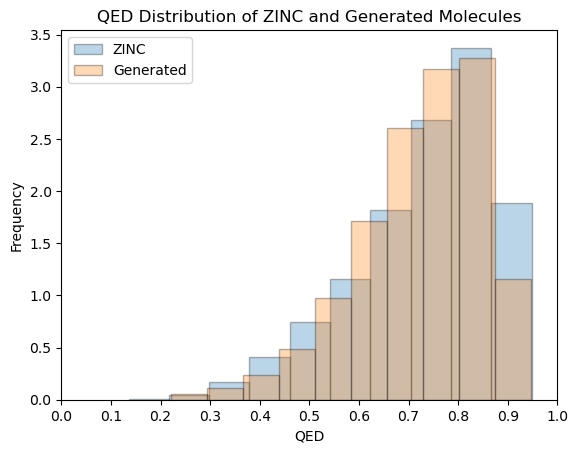

In [7]:
# Task 4: Plot the QED score distribution of ZINC and the generated molecules
# Hint: RDKit has a function that computes the QED score

### YOUR CODE #####
from rdkit.Chem.QED import qed
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# helper function to compute QED - qed function raises an error if there 
# are chemistry violations in the Mol object such as invalid valency
def get_qed(mol):
    try:
        return qed(mol)
    except Exception:
        return 'nan'
    
# make a DataFrame for the ZINC SMILES and compute the QED scores
zinc_df = pd.DataFrame({'smiles': zinc})
zinc_df['qed'] = zinc_df['smiles'].apply(lambda x: get_qed(Chem.MolFromSmiles(x)))

# make a DataFrame for the generated molecules and compute the QED scores
sampled_df = pd.DataFrame({'mols': generated_molecules})
sampled_df['qed'] = sampled_df['mols'].apply(get_qed)

# in case QED could not be computed for some molecules due to some error, remove these
zinc_df = zinc_df.loc[zinc_df['qed'] != 'nan']
sampled_df = sampled_df.loc[sampled_df['qed'] != 'nan']

# plot to compare distributions
# "density=True" normalizes the counts since there are more ZINC SMILES than generated SMILES
zinc_df['qed'].plot(kind='hist', edgecolor='k', alpha=0.3, density=True, label='ZINC')
sampled_df['qed'].plot(kind='hist', edgecolor='k', alpha=0.3, density=True, label='Generated')
plt.xlabel('QED'); plt.title('QED Distribution of ZINC and Generated Molecules');
plt.xticks(np.arange(0, 1.1, 0.1)); plt.legend();

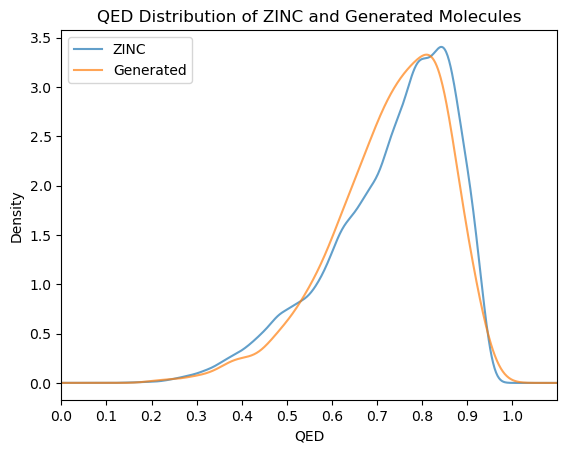

In [8]:
# here's a another view with the "Kernel Density Estimate (KDE))" (estimates the probability distribution)
# create a new instance of figure so we start from a clean slate
plt.figure()
# plot the KDE
zinc_df['qed'].plot(kind='density', alpha=0.7, label='ZINC')
sampled_df['qed'].plot(kind='density', alpha=0.7, label='Generated')
plt.xlabel('QED'); plt.title('QED Distribution of ZINC and Generated Molecules');
plt.xticks(np.arange(0, 1.1, 0.1)); plt.xlim(0, 1.1); plt.legend();

The QED of the generated molecules overlaps with the training data! (actually the pre-trained model provided wasn't trained to the full extent. "Proper" training of generative models will show even more significant overlap). We refer the reader to this [paper](https://www.nature.com/articles/s41467-022-30839-x) - check out the figures showing overlap! You've now verified that `Molecular Generative Models` reproduce the properties of the molecules in the training data 🤩 

Now let's answer the big question from this section: **Is it a `Molecular Generative Model` or a Mime?** Let's recap our findings:

1. The model can generate `SMILES` that are not in the training data
2. The properties of the generated `SMILES` overlap with the training data

The answer is that `Molecular Generative Models` are kind of like a mime. You can generate new molecules that fit into the properties distribution in your training data. When could this be useful? Imagine you have a dataset of molecules with properties in the range that you are interested in. The out-of-the-box `Molecular Generative Models` can give you new molecules within this properties range! **What if you want to generate molecules outside the training data properties distribution?** Turns out what we presented here is the foundation for coupling optimization algorithms which can ***shift*** the probability distribution of the `Molecular Generative Model` to the property ranges you want. Next week, you will see this first-hand with a practical tutorial on `REINVENT`.

Finally, let's just take a look at some of the generated molecules.

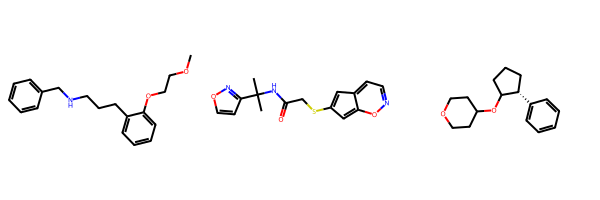

In [9]:
# Task 5: Visually inspect a few of the generated molecules

### YOUR CODE #####
from rdkit.Chem import Draw

# reasonable looking?
Draw.MolsToGridImage(generated_molecules[:3])

Let's now show another `Molecular Generative Model` class.

# 2. Variational Autoencoder (VAE)

*Image was generated using [Stable Diffusion](https://stablediffusionweb.com/#demo). The prompt was "a chef flattens a pancake"*

<div align="middle">
<img src="../images/pancakes.png" width="500"/>
</div>

What do pancakes have to do with `VAEs`? (but also let me know where the best pancakes in Lausanne are 🥞) In this section, we present a high-level overview of what `VAEs` do. Imagine you have a stack of pancakes, some with blueberries and some with raspberries. You then take the biggest spatula you can find and squash it such that you can't even distinguish the pancakes from each other anymore - they are all combined together into a giant pancake like in the image. Now imagine the surface of this giant flat pancake. You start looking around and you notice some blueberries and think to yourself, "this must have came from the blueberry pancake originally". You look around some more and you see another piece of pancake but with both blueberries and raspberries. There were no original pancakes with both berries so you conclude that this piece of pancake must have been from a little bit of the blueberry pancake and a little bit of the raspberry pancake.

Remembering this analogy, we now present a high-level overview of `VAEs` starting with a classic image of the model. This particular image is from [Saul Dobilas](https://towardsdatascience.com/vae-variational-autoencoders-how-to-employ-neural-networks-to-generate-new-images-bdeb216ed2c0).

<div align="middle">
<img src="../images/vae.png" width="900"/>
</div>

The `Encoder` takes molecules and converts it into a low-dimensional vector and maps it onto a `Gaussian Distribution`. Recall that `Gaussian Distributions` are completely defined by their `mean` and `variance`. Specifically, knowing both the `mean` and `variance` allows you to construct the full `Gaussian Distribution`. The `Latent Vector` is now computed based on the `mean` and `variance` but with some noise added to it. In the image, this noise is drawn from a `Gaussian Distribution`. The job of the `Decoder` is to take this `Latent Vector` and `reconstruct` the input.

Let's tie this back to the pancakes analogy. By converting all molecules into a low-dimensional vector via the `Encoder`, a continuous `Latent Space` is created. We squash all our blueberry and raspberry pancakes into a single giant pancake (we take all our molecules and "flatten" them). The model can be trained to `reconstruct` the blueberry pancake (some molecule) given the squashed blueberry pancake (the `Latent Vector`). What happens when you get to the pancake piece that has both blueberries and raspberries? By defining a continuous `Latent Space`, the `reconstructed` molecule from this chunk of pancake is a hybrid between blueberry and raspberry. This is where the `Generative Molecular Model` comes in: by sampling `Latent Vectors` from the `Latent Space`, the `Decoder` can `reconstruct` different molecules back!

In the [original molecular `VAE` paper](https://pubs.acs.org/doi/10.1021/acscentsci.7b00572), they train a neural network model to predict properties in the `Latent Space`. They also show how you can move in the `Latent Space` to go from some starting molecule to another molecules with desired properties. Here, we omit further details and instead try to visually demonstrate what the `Latent Space` is.

**Note:** All the code from this section is taken from 
[Akshay Subramanian](https://aksub99.github.io/) who reimplemented the original [VAE](https://pubs.acs.org/doi/10.1021/acscentsci.7b00572) in `PyTorch` in this [Jupyter notebook](https://github.com/aksub99/molecular-vae/blob/master/Molecular_VAE.ipynb)

The code is shown here but you do not have to go over anything/everything. It is shown here to highlight the key steps that occur. Some comments have been added to map the big idea of what is happening back to the `VAE` image above.

**Further Note:** There are no tasks in this section

In [10]:
# imports 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
import gzip
import pandas
import h5py
import numpy as np
from __future__ import print_function
import argparse
import os
import h5py
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn import model_selection

In [11]:
# these are utility functions
def one_hot_array(i, n):
    return map(int, [ix == i for ix in xrange(n)])

def one_hot_index(vec, charset):
    return map(charset.index, vec)

def from_one_hot_array(vec):
    oh = np.where(vec == 1)
    if oh[0].shape == (0, ):
        return None
    return int(oh[0][0])

def decode_smiles_from_indexes(vec, charset):
    return b"".join(map(lambda x: charset[x], vec)).strip()

def load_dataset(filename, split = True):
    h5f = h5py.File(filename, 'r')
    if split:
        data_train = h5f['data_train'][:]
    else:
        data_train = None
    data_test = h5f['data_test'][:]
    charset =  h5f['charset'][:]
    h5f.close()
    if split:
        return (data_train, data_test, charset)
    else:
        return (data_test, charset)

In [12]:
# the main code for the VAE
class MolecularVAE(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder related blocks
        self.conv_1 = nn.Conv1d(120, 9, kernel_size=9)
        self.conv_2 = nn.Conv1d(9, 9, kernel_size=9)
        self.conv_3 = nn.Conv1d(9, 10, kernel_size=11)
        self.linear_0 = nn.Linear(70, 435)
        self.linear_1 = nn.Linear(435, 292)
        self.linear_2 = nn.Linear(435, 292)

        # decoder related blocks
        self.linear_3 = nn.Linear(292, 292)
        self.gru = nn.GRU(292, 501, 3, batch_first=True)
        self.linear_4 = nn.Linear(501, 33)

        # activation function 
        self.relu = nn.ReLU()
        
    def encode(self, x):
        # forward pass through encoder (pancake squashing!)
        x = self.relu(self.conv_1(x))
        x = self.relu(self.conv_2(x))
        x = self.relu(self.conv_3(x))
        x = x.view(x.size(0), -1)
        x = F.selu(self.linear_0(x))
        return self.linear_1(x), self.linear_2(x)

    def sampling(self, z_mean, z_logvar):
        # recall in the VAE figure, noise is added
        # epsilon is the noise
        epsilon = 1e-2 * torch.randn_like(z_logvar)
        # return the latent vector (this is what the decoder will use to reconstruct the input)
        return torch.exp(0.5 * z_logvar) * epsilon + z_mean

    def decode(self, z):
        # forward pass through decoder to go from latent vector back to a molecule
        z = F.selu(self.linear_3(z))
        z = z.view(z.size(0), 1, z.size(-1)).repeat(1, 120, 1)
        output, hn = self.gru(z)
        out_reshape = output.contiguous().view(-1, output.size(-1))
        y0 = F.softmax(self.linear_4(out_reshape), dim=1)
        y = y0.contiguous().view(output.size(0), -1, y0.size(-1))
        return y

    def forward(self, x):
        # the overall forward pass takes the input, passes it to the encoder and then decoder
        # first encode your input to get the mean and variance of the Gaussian distribution it is mapped to
        z_mean, z_logvar = self.encode(x)
        # get the latent vector taking the mean and variance above and adding noise t it
        z = self.sampling(z_mean, z_logvar)
        # decode the latent vector, z, to reconstruct a molecule
        return self.decode(z), z_mean, z_logvar
    
def vae_loss(x_decoded_mean, x, z_mean, z_logvar):
    # the loss function is a combination of 2 quantities:
    #     1. "reconstruction loss" which measures how different the reconstructed molecule 
    #        is to the original. We would want them to be similar
    
    #     2. "Kullback–Leibler (KL) divergence". We are trying to approximate the distribution
    #         of the latent vector with a Gaussian distribution. The KL divergence measure how "off" we are
    reconstruction_loss = F.binary_cross_entropy(x_decoded_mean, x, size_average=False)
    kl_loss = -0.5 * torch.sum(1 + z_logvar - z_mean.pow(2) - z_logvar.exp())
    return reconstruction_loss + kl_loss

In [13]:
# this was used when we pre-trained the VAE
# it initializes a PyTorch DataLoader so we can read batches of molecules at a time during training
data_train, data_test, charset = load_dataset('data/vae.training.data.h5')
data_train = torch.utils.data.TensorDataset(torch.from_numpy(data_train))
train_loader = torch.utils.data.DataLoader(data_train, batch_size=500, shuffle=True)

In [14]:
# initiate an instance of the MolecularVAE 
pretrained_vae = MolecularVAE()
# load the pre-trained model (we provide this)
pretrained_vae.load_state_dict(torch.load('data/pretrained.vae.pt'))

<All keys matched successfully>

Starting below, we will visualize the `Latent Space`.

In [15]:
# RERUN HERE FOR NEW MOLECULES!
# this bit of code randomly takes 500 molecules from the training data
for batch in train_loader:
    training_data_molecules = batch

In [16]:
# manually add some noise to the training data molecules --> we will see 
# what these "noised" molecules look like in the latent space later
num_noised = 10

noised_molecules = training_data_molecules[0][:num_noised] + torch.normal(0, 0.0001, (num_noised, 120, len(charset)))

In [17]:
# this bit of code gets the SMILES back from the 500 training data molecules we got above
smiles_list = []
for idx in range(training_data_molecules[0].shape[0]):
    vector = training_data_molecules[0][idx].reshape(1, 120, len(charset)).argmax(axis=2)[0]
    smiles = decode_smiles_from_indexes(vector, charset)
    smiles = str(smiles).replace("'", '').replace('b', '')
    smiles_list.append(smiles)

In [18]:
# this bit of code gets the SMILES from the "noised" training data molecules
noised_smiles_list = []
for idx in range(noised_molecules.shape[0]):
    vector = noised_molecules[idx].reshape(1, 120, len(charset)).argmax(axis=2)[0]
    smiles = decode_smiles_from_indexes(vector, charset)
    smiles = str(smiles).replace("'", '').replace('b', '')
    noised_smiles_list.append(smiles)

In [19]:
# encode the training data SMILES
z_mean, z_logvar = pretrained_vae.encode(training_data_molecules[0])
# get the latent space
latent_space = pretrained_vae.sampling(z_mean, z_logvar)

# encode the noised data
noised_z_mean, noised_z_logvar = pretrained_vae.encode(noised_molecules)
# get the latent space of the "noised" molecules
noised_latent_space = pretrained_vae.sampling(noised_z_mean, noised_z_logvar)

In [21]:
# the code here plots an interative latent space - hover around the space and explore the molecules!
import plotly
import plotly.express as px
import molplotly
import pandas as pd 

all_smiles = smiles_list + noised_smiles_list
full_latent_space = torch.vstack([latent_space, noised_latent_space])

plotting_df = pd.DataFrame({'smiles': all_smiles,
                           'group': ['Training Data']*500 + ['Sampled from Latent Space']*num_noised,
                           'latent_space_x': full_latent_space[:, 0].detach(),
                           'latent_space_y': full_latent_space[:, 1].detach()})

fig_scatter = px.scatter(plotting_df,
                         x='latent_space_x',
                         y='latent_space_y',
                         color='group')
    
app_scatter = molplotly.add_molecules(fig=fig_scatter,
                                      df=plotting_df,
                                      smiles_col='smiles',
                                      title_col='group',
                                      color_col='group')

app_scatter.run_server(mode='inline', height=400)

# the red points are the "sampled" molecules created from adding "noise" to the latent vectors of the
# training data molecules. Here, let's bring back the analogy of the blueberry and raspberry pancakes.
# Locate a red point and look at the training data points around it. You should be able to see some 
# structural similarities. One can think of the red point as a "hybrid" between its surrounding neighbours
# of blue points, i.e., it's a hybrid between blueberry and raspberry 

# Note: it could be that sometimes "close" points are not that similar - this has to do with the "smoothness"
#       of the latent space such that there are abrupt changes

# Finally, if you want to see new molecules, re-run the cell above marked with "RERUN HERE FOR NEW MOLECULES!"

Dash is running on http://127.0.0.1:8050/

